In [20]:
# Import MAESTRI dataset

# Import correspondence tables

# Match ISIC, WZ and SSIC codes to NACE codes

## ISIC doesn't need NLP

## WZ and SSIC have multiple codes for a given NACE code

### Use a LLM to find the best match given extra info

### 0. Utilities

#### Imports

In [21]:
import numpy as np
import pandas as pd
import re
import ollama
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [22]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from utils.constants import STANDARDS, DIFF_THRESHOLD, EXPORTS_PATH
from utils.types import IndustryStandard, IndustryCode
from utils.inference import read_inference
from utils.correspondence import read_correspondence
from utils.maestri import read_maestri, NEW_MAESTRI_ROLES, get_new_code_col, MAESTRI_DESC_COL
from utils.similarity import str_to_codes, get_similarity, get_similarity_col

In [23]:
class NACECompany:
    def __init__(self, code: str, desc: str):
        self.code = IndustryCode(IndustryStandard.NACE, code)
        self.description = desc

#### Constants

In [24]:
# Non-NACE standards
NON_NACE_STDS = STANDARDS[1:]

inference_dfs = read_inference()

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [25]:
# Read the MAESTRI dataset as a DataFrame
maestri_dfs = read_maestri()

def simplify_nace_code_str(string):
    if "," in string:
        return string.split(",")[0]
    
    return string.split(";")[0]

for i in range(len(NEW_MAESTRI_ROLES)):
    role = NEW_MAESTRI_ROLES[i]
    nace_col = get_new_code_col(IndustryStandard.NACE)

    maestri_dfs[i][nace_col] = maestri_dfs[i][nace_col].map(simplify_nace_code_str)

In [26]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,WZ code,SSIC code
0,Refinery,1920,1920,19200,19201
1,Refinery,1920,1920,19200,19201
2,Steelworks,2410,2410,24520,24310
3,Steelworks,2410,2410,24520,24310
4,Cement production,2351,2394,23510;23650;23610,23940


In [27]:
correspondence_dfs = read_correspondence()
inference_dfs = read_inference()

In [28]:
def get_level(code) -> int:
    df = inference_dfs[code.std]
    
    if code.value in df.index:
        return df.loc[code.value, "Level"]

    return None

def get_children(code):
    df = inference_dfs[code.std]
    
    if code.value == "" or code.value in df.index:
        return [IndustryCode(code.std, value) for value in df[df["Parent"] == code.value].index]

    return None

def get_parent(code, level=-1):
    df = inference_dfs[code.std]
    
    if code.value in df.index:        
        v = df.loc[code.value, "Parent"]
        l = df.loc[v, "Level"]
        
        # Level == -1 (immediate parent)
        while level != -1 and l > level:
            v = df.loc[v, "Parent"]
            l = df.loc[v, "Level"]
        
        return IndustryCode(code.std, v)

    print(code.value)
    return None

# Evaluate the highest common level (HCL)
def get_common_parent(code, std):
    # from_df = inference_dfs[code.std]
    to_df = inference_dfs[std]
    level = get_level(code)
    
    if level == 1:
        return IndustryCode(std, "")
    
    parent = get_parent(code)
    
    if parent.value in to_df.index and len(get_children(parent)) > 0:
        return IndustryCode(std, parent.value)
    
    while parent.value not in to_df.index:
        # print(std.value + ": " + c.value)
        parent = get_parent(parent)
        # print(parent.value)
    
    return IndustryCode(std, parent.value)

In [29]:
def get_detailed_code_str(code):
	df = inference_dfs[code.std].copy()
    
	if code.value in df.index:
		series = df.loc[code.value]
		series = series[series.index[~series.index.isin(["Level", "Parent", "ISIC code"])]]
		string = f"{code.std.value} Code: {series.name}\n"

		for col in series.index:
			if series[col] != "":
				text = re.sub(r"\s*\(\d+\.\d+(?:\,\s*\d+\.\d+)*\)", "", series[col])
				text = text.replace("\n", "")
				
				string += f"{col}: {text}\n"
						
		return string.strip()

	return None

def get_detailed_company_str(company):
	return f"Company description: {company.description}\n{get_detailed_code_str(company.code)}"

def get_match_prompt(company, to_codes):
    from_std = company.code.std
    to_std = to_codes[0].std
    
    prompt = f"Classify the company below given its {from_std.value} code and description to the most similar" \
			 f" of the following {to_std.value} codes using their descriptions, examples and exclusions. When" \
       		 f" returning the result as JSON, the keys for the given code should be '{from_std.value}' and for" \
    		 f" the matched code as '{to_std.value}':\n\n{get_detailed_company_str(company)}"
    
    for code in to_codes:
        prompt += "\n\n" + get_detailed_code_str(code)
    
    return prompt

In [30]:
# def get_match_prompt_from_common_parent(from_code, to_std):
#     common_parent = get_common_parent(from_code, to_std)
#     return get_match_prompt(from_code, get_children(common_parent))

# c = IndustryCode(IndustryStandard.SSIC, "01")
# print(get_match_prompt_from_common_parent(c, IndustryStandard.WZ))

### 2. Obtaining similarity scores for validation

In [31]:
def get_match(company, to_std, to_guesses_str):
	from_code = company.code
	# print(from_code.std.value, from_code.value, to_std.value, to_guesses_str)

	to_codes = [code for code in str_to_codes(to_guesses_str, to_std) if get_parent(code, level=1).value == get_parent(from_code, level=1).value]

	if len(to_codes) == 0:
		return ""
	elif len(to_codes) == 1:
		return to_codes[0].value

	# print(f"Given {from_code.std.value} code: {from_code.value}, given {to_std.value} codes: {to_guesses_str}")

	prompt = get_match_prompt(company, to_codes)
	# print("Prompt: " + prompt)

	response = ollama.generate(model='llama3', prompt=prompt, format="json", options={"temperature": 0.3})
	response = json.loads(response["response"])
	# print(f"Given {from_code.std.value} code: {from_code.value}, matched {to_std.value} code: {response[to_std.value]}")

	# return IndustryCode(to_std, "")
	return response[to_std.value]

In [32]:
# Loop through all company types
for i in range(len(NEW_MAESTRI_ROLES)):
    # Role: either 'Donor', 'Intermediary' or 'Receiver'
    role = NEW_MAESTRI_ROLES[i]
    # role = "Intermediary"
    
    # NACE column, example: 'Provider NACE code'
    nace_col = get_new_code_col(STANDARDS[0])

    print(role)
    
    # Iterate through all standards except NACE as it is to be compared with
    for std in NON_NACE_STDS:
        print(std.value)

        df = maestri_dfs[i]
        
        # Standard column, example for ISIC: 'Donor ISIC code'
        std_col = get_new_code_col(std)

        similarity_col = get_similarity_col(std)
        
        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[MAESTRI_DESC_COL], df[std_col])
        
        ### -> INTRODUCE SIMILAR CODES HERE
        df[std_col] = [get_match(    NACECompany(t[0], t[1]), std, t[2]    ) for t in tuples]

        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[std_col])
        
        # Append the similarity score column of a certain standard to the DataFrame for a given role
        df[similarity_col] = [get_similarity(a[0], IndustryStandard.NACE, a[1], std) for a in tuples]
        
        # Convert the similarity score column data type to 'float'
        df[similarity_col] = df[similarity_col].astype(float)
        
    # List containing new order of columns for readability
    cols = [MAESTRI_DESC_COL, nace_col] + [f(std) for std in NON_NACE_STDS for f in (get_new_code_col, get_similarity_col)]
    
    # Reorder columns for readability
    maestri_dfs[i] = maestri_dfs[i][cols]

Donor
ISIC
WZ
SSIC
Intermediary
ISIC
WZ
SSIC
Receiver
ISIC
WZ
SSIC


In [33]:
maestri_dfs[0].head()

,Company description,NACE code,ISIC code,ISIC code sim. score,WZ code,WZ code sim. score,SSIC code,SSIC code sim. score
0,Refinery,1920,1920,1.0,19200,1.0,19201,1.0
1,Refinery,1920,1920,1.0,19200,1.0,19201,1.0
2,Steelworks,2410,2410,1.0,24520,1.0,24310,1.0
3,Steelworks,2410,2410,1.0,24520,1.0,24310,1.0
4,Cement production,2351,2394,1.0,23510,1.0,23940,1.0


### 3. Model performance statistics

In [34]:
# Score ategories
score_categories = ["s = 0", "0 < s < 1", "s = 1"]

# Determine counts for a given series
get_counts = lambda f: lambda x: {
    "s = 0": [len(arr[(arr == 0)]) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) for arr in f(x)]
}

# Determine percents for a given series
get_percents = lambda f: lambda x: {
    "s = 0": [len(arr[arr == 0]) / len(arr) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) / len(arr) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) / len(arr) for arr in f(x)]
}

#### By company role and industry classification standards

In [37]:
# Function to extract all scores by role
scores_by_role = lambda std: [np.array(df[get_similarity_col(std)]) for df in maestri_dfs]

# Function to calculate score count breakdown (by role)
scores_counts_by_role = get_counts(scores_by_role)

# Function to calculate score percentage (by role) breakdown
scores_percents_by_role = get_percents(scores_by_role)

#### By industry classification standard

In [38]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

#### Text representation

In [39]:
# Print statistics by ICS
score_stats = {std: score_counts_dict["s = 1"][i] / sum([score_counts_dict[cat][i] for cat in score_categories]) for i, std in enumerate(NON_NACE_STDS)}

for std in NON_NACE_STDS:
    print("{0:>4}   {1:>6.2f}%".format(std.value, score_stats[std] * 100))

ISIC   100.00%
  WZ    73.20%
SSIC    67.81%


#### Visualising similarity scores

In [40]:
# Bar width for every plot
bar_width = 0.3

##### By company role and industry classification standard

In [41]:
# Create a subplot based on a given ICS
def score_subplot(std, ax, is_percent=False):
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = scores_percents_by_role(std) if is_percent else scores_counts_by_role(std)
    
    # Initial bar heights
    bottom = np.zeros(len(values_dict))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all roles ('Donor', 'Intermediary', 'Receiver')
        ax.bar(NEW_MAESTRI_ROLES, values, bar_width, label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # Set the title of the subplot
    ax.set_title(std.value)
    
    # Rotate the x-ticks by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

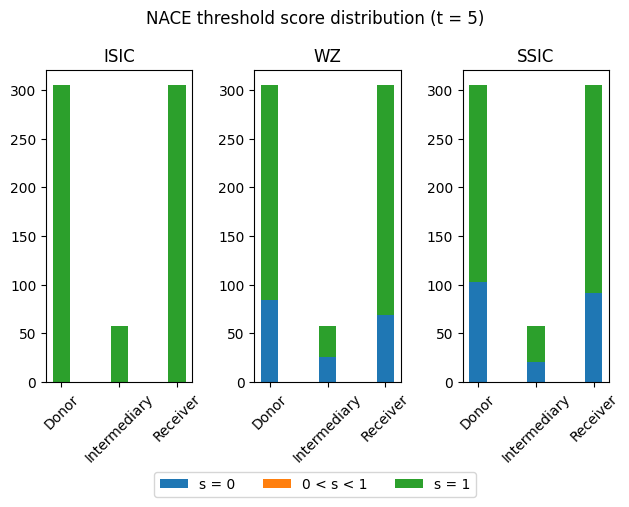

In [42]:
fig, axs = plt.subplots(ncols=len(NON_NACE_STDS))

# Add subplots for each standard
for std, ax in zip(NON_NACE_STDS, axs):
    score_subplot(std, ax)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(NEW_MAESTRI_ROLES), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

# Add enough padding between subplots to prevent overlapping
fig.tight_layout()

plt.show()

##### By industry classification standard

In [43]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(NON_NACE_STDS)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(NON_NACE_STDS)

In [44]:
# Create a subplot based on a given ICS
def score_plot(ax, is_percent=False):
    # x-axis values
    x = [std.value for std in NON_NACE_STDS]
    
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = score_percents_dict if is_percent else score_counts_dict
    
    # Initial bar heights
    bottom = np.zeros(len(values_dict))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for std, values in values_dict.items():
        # Add bars for each category for all standards ('ISIC', 'WZ', 'SSIC')
        ax.bar(x, values, bar_width, label=std, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

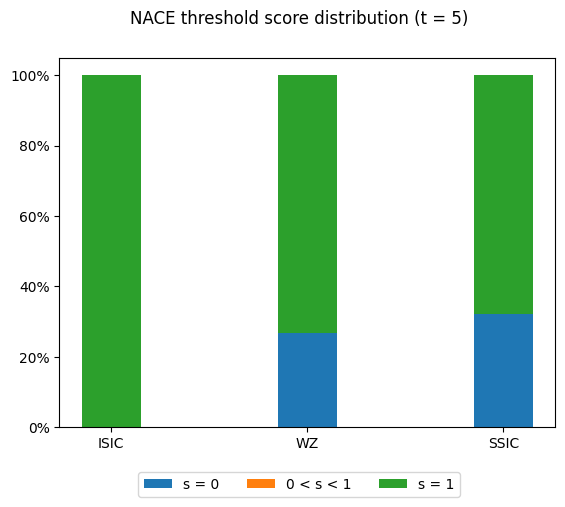

In [45]:
fig, ax = plt.subplots()

# Add bars to the figure
score_plot(ax, is_percent=True)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(NON_NACE_STDS), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE threshold score distribution (t = {DIFF_THRESHOLD})")

plt.show()

### 4. Exporting results to Excel

In [46]:
with pd.ExcelWriter(f"{EXPORTS_PATH}/Exchanges-database Maestri_new.xlsx") as writer:
    for i in range(len(maestri_dfs)):
        role = NEW_MAESTRI_ROLES[i]
        df = maestri_dfs[i]
        
        df.to_excel(writer, sheet_name=role, index=False)
        worksheet = writer.sheets[role]
        workbook = writer.book
        
        format = workbook.add_format()
        format.set_align('left')
        format.set_align('vcenter')
        
        # Loop through all columns
        for index, col in enumerate(df):
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # Length of largest item
                len(str(series.name))               # Length of column name/header
            ))
            
            # Set column width
            worksheet.set_column(index, index, max_len, format)